In [1]:
# imports
from random import randint
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
from tqdm import trange

# For probability output
import tensorflow_probability as tfp

# import my_dataset
import matplotlib.pyplot as plt
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

In [2]:
# functions

def ModelProba(nb_summaries):
    """ Creates a CNN with probabilistic output
    """
    num_components = 16
    event_shape = [1]
    return tf.keras.Sequential([
        tfkl.Input(shape=(128, 128, 4)),
        tfkl.Conv2D(16, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(32, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
        tfkl.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
        tfkl.Flatten(),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(tfp.layers.MixtureNormal.params_size(num_components, event_shape),
                   activation='softplus'),
        tfp.layers.MixtureNormal(num_components, event_shape),
        ])

def preprocessing(example):
    # Magic constants (from mergers_kin_scripts)
    std_noiseless_griz = 9.816043
    stellar_light_compression = 3.0
    img0 = example['noiseless_griz']
    img0 = tf.where(tf.math.is_nan(img0), tf.zeros_like(img0), img0)
    img0 = tf.where(tf.math.is_inf(img0), tf.zeros_like(img0), img0)
    img0 = tf.math.asinh(img0 / tf.constant(std_noiseless_griz) * tf.constant(stellar_light_compression) ) / tf.constant(stellar_light_compression)

    return img0, example['Mstar_Half'][0]

def preprocessing_test(example):
    # Magic constants (from mergers_kin_scripts)
    std_noiseless_griz = 9.816043
    stellar_light_compression = 3.0
    
    img0 = example['noiseless_griz']
    img0 = tf.where(tf.math.is_nan(img0), tf.zeros_like(img0), img0)
    img0 = tf.where(tf.math.is_inf(img0), tf.zeros_like(img0), img0)
    img0 = tf.math.asinh(img0 / tf.constant(std_noiseless_griz) * tf.constant(stellar_light_compression) ) / tf.constant(stellar_light_compression)

    return img0, example['Mstar_Half'][0], example['Mstar_Half'], example['time'], example['mass_quantiles']

def input_fn(mode='train', batch_size=32):
    """
    mode: 'train' or 'test'
    """
    def has_sfh(example):
        print(example)
        return not tf.reduce_all(example['Mstar_Half'] == 0)

    if mode == 'train':
        dataset = tfds.load('tng100', split='train[:80%]', data_dir=data_dir)
        dataset = dataset.filter(has_sfh) # adding a filtering condition to exclude empty catalogs
        dataset = dataset.map(preprocessing) # Apply data preprocessing
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
    else:
        dataset = tfds.load('tng100', split='train[80%:]', data_dir=data_dir)
        #dataset = dataset.filter(lambda x: x['has_sfh'] == True) # adding a filtering condition to exclude empty catalogs
        #dataset = dataset.filter(lambda x: x['last_over_max'] > 0.9) # adding a filtering condition to gold samples
        dataset = dataset.map(preprocessing_test) # Apply data preprocessing
    
    dataset = dataset.batch(batch_size, drop_remainder=True)

    dataset = dataset.prefetch(-1)  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [3]:
model_proba = ModelProba(1)
model_proba.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        592       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dense_1 (Dense)              (None, 48)                6

2021-12-09 16:04:00.479541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 16:04:01.127402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2021-12-09 16:04:01.514376: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [4]:
def negloglik(y_true, y_pred):
    # instead of tf.keras.losses.MSE
    return -y_pred.log_prob(y_true)

model_proba.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=negloglik, metrics=['accuracy'])
label = 'img_cnnproba_last-mass'
EPOCHS = 40
now = str(datetime.datetime.now())[0:16].replace('-','_').replace(' ','_').replace(':','_')
checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/'+label+'/'+now
model_proba_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

In [5]:
LEARNING_RATE=0.0001
LEARNING_RATE_EXP_DECAY=0.9

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

dset = input_fn(mode='train', batch_size=32)
history = model_proba.fit(dset, steps_per_epoch=200, epochs=EPOCHS, callbacks=[model_proba_checkpoint_callback, lr_decay])

{'Mstar': <tf.Tensor 'args_0:0' shape=(100,) dtype=float32>, 'Mstar_Half': <tf.Tensor 'args_1:0' shape=(100,) dtype=float32>, 'SFR_Max': <tf.Tensor 'args_2:0' shape=(100,) dtype=float32>, 'SFR_Rad': <tf.Tensor 'args_3:0' shape=(100,) dtype=float32>, 'SFR_halfRad': <tf.Tensor 'args_4:0' shape=(100,) dtype=float32>, 'last_major_merger': <tf.Tensor 'args_5:0' shape=() dtype=float32>, 'last_over_max': <tf.Tensor 'args_6:0' shape=() dtype=float32>, 'mass_quantiles': <tf.Tensor 'args_7:0' shape=(9,) dtype=float32>, 'noiseless_griz': <tf.Tensor 'args_8:0' shape=(128, 128, 4) dtype=float32>, 'object_id': <tf.Tensor 'args_9:0' shape=() dtype=int32>, 'sed': <tf.Tensor 'args_10:0' shape=(143,) dtype=float32>, 'stellar_light': <tf.Tensor 'args_11:0' shape=(512, 512) dtype=float32>, 'time': <tf.Tensor 'args_12:0' shape=(100,) dtype=float32>, 'velocity_dispersion_map': <tf.Tensor 'args_13:0' shape=(512, 512) dtype=float32>, 'velocity_map': <tf.Tensor 'args_14:0' shape=(512, 512) dtype=float32>}
Epoc

2021-12-09 16:04:02.618203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 16:04:12.774504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 8855 of 10000
2021-12-09 16:04:13.398528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-09 16:04:13.983139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


200/200 [==============================] - 20s 30ms/step - loss: 2.1833 - accuracy: 0.0000e+00
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 9e-05.
200/200 [==============================] - 6s 29ms/step - loss: 0.8903 - accuracy: 0.0000e+00
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 8.1e-05.
200/200 [==============================] - 5s 27ms/step - loss: 0.8045 - accuracy: 0.0000e+00
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 7.290000000000001e-05.
200/200 [==============================] - 5s 27ms/step - loss: 0.7619 - accuracy: 0.0000e+00
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 6.561e-05.
200/200 [==============================] - 5s 27ms/step - loss: 0.7522 - accuracy: 0.0000e+00
Epoch 6/40

Epoch 00006: LearningRateScheduler setting learning rate to 5.904900000000001e-05.
200/200 [==============================] - 6s 30ms/step - loss: 0.7452 - accuracy: 0.0000e+00
Ep

In [6]:
# To read the model from disk
if False:
    checkpoint_filepath = '/gpfsscratch/rech/qrc/commun/sfhsed/checkpoint/img_cnnproba_last-mass/2021_12_09_14_26'
    status = model_proba.load_weights(checkpoint_filepath)

Text(0.5, 1.0, 'Log Likelihood Loss history')

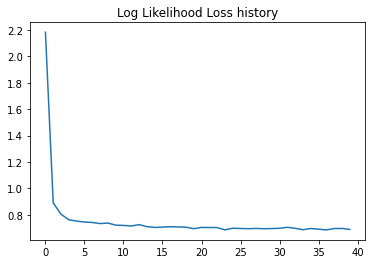

In [7]:
plt.figure()
plt.plot(np.arange(len(model_proba.history.history['loss'])), model_proba.history.history['loss'])
#plt.yscale('log')
plt.title('Log Likelihood Loss history')

In [8]:
dset_test = input_fn(mode='test', batch_size=128)
features = dset_test.take(1)

In [9]:
i = 0
truthes = []
predicted_mean = []
predicted_std = []
for ibatch, features in enumerate(dset_test):
    truth = features[1]
    truthes.append(truth)
    predict = model_proba(features[0])
    predicted_mean.append(predict.mean())
    predicted_std.append(predict.stddev())
    i = i + 1
truthes = np.ravel(truthes)
predicted_mean = np.ravel(predicted_mean)
predicted_std = np.ravel(predicted_std)

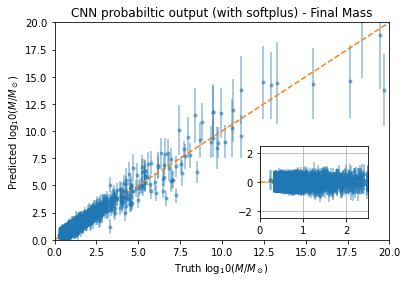

In [25]:
plt.errorbar(truthes, predicted_mean, predicted_std, marker='.', ls='', alpha=0.5)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.plot([0, 20], [0, 20], '--')
plt.title('CNN probabiltic output (with softplus) - Final Mass')
plt.xlabel('Truth $\log_10(M/M_\odot$)')
plt.ylabel('Predicted $\log_10(M/M_\odot$)')
zoom_axes = plt.axes([0.6, 0.2, 0.25, 0.25])
zoom_axes.errorbar(truthes, predicted_mean - truthes, predicted_std, marker='.', ls='', alpha=0.5)
#zoom_axes.plot([0, 2.5], [0, 2.5], '--')
zoom_axes.axhline(0.0, color='orange', ls='--')
zoom_axes.set_xlim(0, 2.5)
zoom_axes.set_ylim(-2.5, 2.5)
zoom_axes.grid()
plt.savefig('cnn_proba_softplus_image_final_mass_predicted_vs_truth.pdf')

Text(0, 0.5, 'Predicted $\\log_10(M/M_\\odot$)')

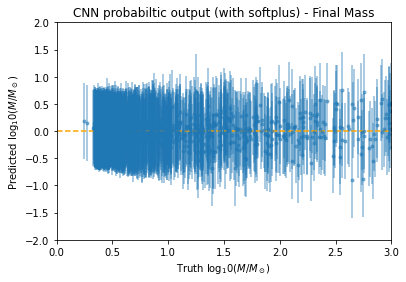

In [15]:
plt.errorbar(truthes, predicted_mean - truthes, predicted_std, marker='.', ls='', alpha=0.5)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.plot([0, 3], [0, 3], '--')
plt.title('CNN probabiltic output (with softplus) - Final Mass')
plt.xlabel('Truth $\log_10(M/M_\odot$)')
plt.ylabel('Predicted $\log_10(M/M_\odot$)')
#plt.savefig('cnn_proba_softplus_image_final_mass_predicted_vs_truth_zoom.pdf')

In [16]:
plt.axes?

Signature: plt.axes(arg=None, **kwargs)
Docstring:
Add an axes to the current figure and make it the current axes.

Call signatures::

    plt.axes()
    plt.axes(rect, projection=None, polar=False, **kwargs)
    plt.axes(ax)

Parameters
----------
arg : None or 4-tuple
    The exact behavior of this function depends on the type:

    - *None*: A new full window axes is added using
      ``subplot(**kwargs)``.
    - 4-tuple of floats *rect* = ``[left, bottom, width, height]``.
      A new axes is added with dimensions *rect* in normalized
      (0, 1) units using `~.Figure.add_axes` on the current figure.

projection : {None, 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', str}, optional
    The projection type of the `~.axes.Axes`. *str* is the name of
    a custom projection, see `~matplotlib.projections`. The default
    None results in a 'rectilinear' projection.

polar : bool, default: False
    If True, equivalent to projection='polar'.

sharex, sharey : `~.ax